# 由众多条带确定点在条带上的最佳大圆距离阈值

## 导入库

In [39]:
import os
import glob
import h5py
import cartopy
import numpy as np
import pandas as pd
from tqdm import tqdm
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

GeoAxes = cartopy.mpl.geoaxes.GeoAxes

## 输入输出

In [41]:
my_points=[(114.3155556,35.715), (114.66,35.74), (114.13,35.94)]
swath_dir = r"C:\Datasets\RS\AMSR2_L1R_BT-Pass-HeNan\2022"
swath_files = glob.glob(os.path.join(swath_dir, "*.h5"))

## 计算大圆距离



### 定义算法

In [42]:
def greate_circle(point1: tuple, point2: tuple) -> float:
    """
    计算两个经纬度坐标之间的大圆距离

    point1: （经度，纬度）
    point2：（经度，纬度）
    """

    earth_r = 6371007.1810
    lat_dif = np.radians(point1[1] - point2[1]) / 2
    lon_dif = np.radians(point1[0] - point2[0]) / 2
    lat1, lat2 = np.radians(point1[1]), np.radians(point2[1])
    a = np.sin(lat_dif) * np.sin(lat_dif) + np.cos(lat1) * np.cos(lat2) * np.sin(lon_dif) * np.sin(lon_dif)

    return 2 * earth_r * np.arcsin(np.sqrt(a))

### 逐点遍历

In [15]:
all_points_info = []
for my_point in my_points:
    all_points_info.append({"filepath":[], "mini_distance":[],"mini_row":[], "mini_col":[]})

for swath_file in tqdm(swath_files):
    with h5py.File(swath_file) as swath_obj:
        number_scan = int(swath_obj.attrs["NumberOfScans"][0])
        overlap_scan = int(swath_obj.attrs["OverlapScans"][0])
        lat = swath_obj["Latitude of Observation Point for 89A"][:]
        lon = swath_obj["Longitude of Observation Point for 89A"][:]
    
        # cutoff overlap
        lon[0:number_scan] = lon[overlap_scan:number_scan + overlap_scan]
        lat[0:number_scan] = lat[overlap_scan:number_scan + overlap_scan]
        lon, lat = lon[:number_scan], lat[:number_scan]
        
        for i, my_point in enumerate(my_points):
            distance = greate_circle(my_point, (lon, lat))
            mini_dis_loc = distance.argmin()
            mini_dist = distance.min()
            row = mini_dis_loc // distance.shape[1]
            col = mini_dis_loc % distance.shape[1]
            all_points_info[i]["mini_distance"].append(mini_dist)
            all_points_info[i]["filepath"].append(swath_file)
            all_points_info[i]["mini_row"].append(row)
            all_points_info[i]["mini_col"].append(col)

for i, my_point in enumerate(my_points):
    info = all_points_info[i]
    all_points_info[i] = pd.DataFrame(info).sort_values("mini_distance", ignore_index=True)      

all_points_info[0]

100%|██████████████████████████████████████████████████████████████████████████| 771/771 [01:49<00:00,  7.01it/s]


,filepath,mini_distance,mini_row,mini_col
0,C:\Datasets\RS\AMSR2_L1R_BT-Pass-HeNan\2022\GW...,50.691860,622,113
1,C:\Datasets\RS\AMSR2_L1R_BT-Pass-HeNan\2022\GW...,213.469299,618,424
2,C:\Datasets\RS\AMSR2_L1R_BT-Pass-HeNan\2022\GW...,253.797195,1428,28
3,C:\Datasets\RS\AMSR2_L1R_BT-Pass-HeNan\2022\GW...,276.361938,1413,355
4,C:\Datasets\RS\AMSR2_L1R_BT-Pass-HeNan\2022\GW...,349.181641,1395,132
...,...,...,...,...
766,C:\Datasets\RS\AMSR2_L1R_BT-Pass-HeNan\2022\GW...,399690.812500,1435,0
767,C:\Datasets\RS\AMSR2_L1R_BT-Pass-HeNan\2022\GW...,401191.062500,1434,0
768,C:\Datasets\RS\AMSR2_L1R_BT-Pass-HeNan\2022\GW...,405373.125000,1434,0
769,C:\Datasets\RS\AMSR2_L1R_BT-Pass-HeNan\2022\GW...,406566.031250,1435,0


### 画图找规律

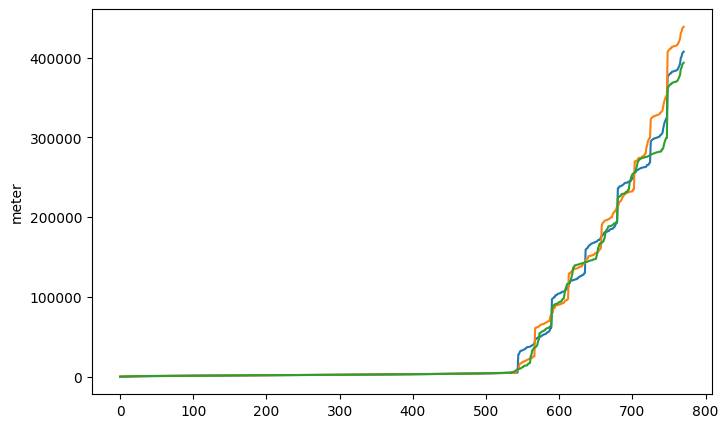

In [16]:
fig:plt.Figure = plt.figure(figsize=[8, 5])
ax:plt.Axes = fig.add_subplot(1, 1, 1)

for point_info in all_points_info:
    ax.plot(range(len(point_info)), point_info["mini_distance"])
    ax.set_ylabel("meter")
plt.show()

### 把突变位置放大

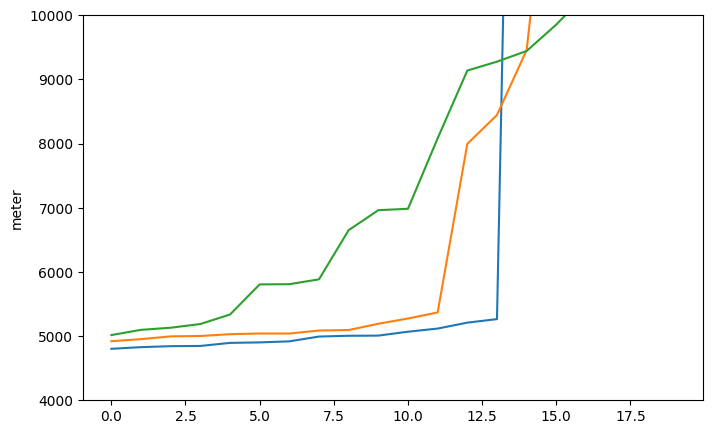

In [33]:
fig:plt.Figure = plt.figure(figsize=[8, 5])
ax:plt.Axes = fig.add_subplot(1, 1, 1)

all_subset = []
for point_info in all_points_info:
    subset = point_info.iloc[530:550, :]
    all_subset.append(subset)
    ax.plot(range(len(subset)), subset["mini_distance"])
    ax.set_ylim(4000,10000)
    ax.set_ylabel("meter")
plt.show()

##### 阈值定在5000米左右。

## 画地图验证阈值

由上述分析可得，三个点在图上的最小距离都在6000到7000之间开始增大，说明这是个临界状态，及是否是是临界，我们要画图看一下。

上步中，我们已经提取了临界范围的subset用于画上图，我们把这些subset对应的条带和点一起画到地图上

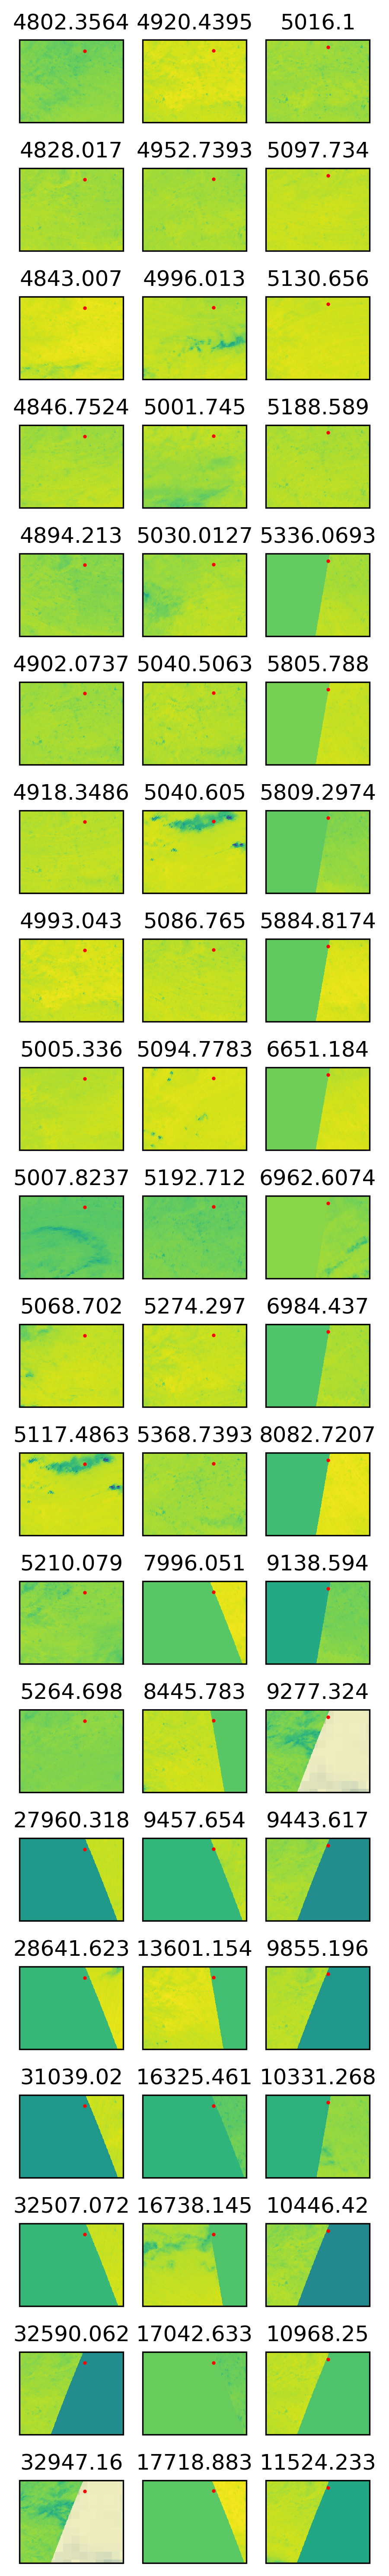

In [45]:
fig = plt.figure(figsize=(3,20), tight_layout=True, dpi=300)

for i, subset in enumerate(all_subset):
    subset = subset.reset_index()
    for j in subset.index:
        with h5py.File(subset.loc[j, "filepath"]) as h5obj:
            number_scan = int(h5obj.attrs["NumberOfScans"][0])
            overlap_scan = int(h5obj.attrs["OverlapScans"][0])
            lat = h5obj["Latitude of Observation Point for 89A"][:]
            lon = h5obj["Longitude of Observation Point for 89A"][:]
            bt_v = h5obj["Brightness Temperature (original,89GHz-A,V)"][:]
                # cutoff overlap
            lon[0:number_scan] = lon[overlap_scan:number_scan + overlap_scan]
            lat[0:number_scan] = lat[overlap_scan:number_scan + overlap_scan]
            bt_v[0:number_scan] = bt_v[overlap_scan:number_scan + overlap_scan]
            lon, lat,  bt_v_arr = lon[:number_scan], lat[:number_scan], bt_v[:number_scan]
            bt_v_arr = np.where(bt_v_arr !=65535, bt_v_arr/100, np.nan)
            
            ax:GeoAxes = fig.add_subplot(20, 3, j*3 + i + 1, projection=ccrs.PlateCarree())
            ax.set_extent([110.3, 116.7, 31.3, 36.4])
            ax.stock_img()
            ax.pcolormesh(lon, lat, bt_v_arr, transform=ccrs.PlateCarree(), )
            ax.plot(my_points[i][0], my_points[i][1], "ro", markersize=1)
            ax.set_title(subset.loc[j, "mini_distance"])
plt.show()

可以看出，当值为7044是就已经出范围了，所以把阈值设置为7000是合理的。